In [1]:
import sys
import os

# Add project root (parent of src) to sys.path
sys.path.append(os.path.abspath(".."))

In [2]:
from modules.variables import *
import os, json, time, requests, random, enum
from datetime import datetime, timedelta
from typing import List, Annotated, Literal, Optional
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
import operator
import pandas as pd
import numpy as np
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.fundamentaldata import FundamentalData
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools import DuckDuckGoSearchResults
from IPython.display import Image, display
from langfuse import Langfuse
from dotenv import load_dotenv
from google.genai import Client, types

/home/rudra/anaconda3/envs/AgenticSol/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [3]:
client = Client(api_key=GOOGLE_API_KEY)

In [5]:
os.environ["LANGFUSE_ENABLED"] = "True"

In [6]:
os.environ["LANGFUSE_ENABLED"] = "False"

In [7]:
LANGFUSE_ENABLED = os.environ.get("LANGFUSE_ENABLED", "False").lower() in ("true", "1", "t")
langfuse = None

if LANGFUSE_ENABLED:
    langfuse = Langfuse(
      secret_key=LANGFUSE_SECRET_KEY,
      public_key=LANGFUSE_PUBLIC_KEY,
      host=LANGFUSE_BASE_URL
    )

In [3]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst")
    specialty: str = Field(description="Analyst's investment specialty")
    focus_areas: List[str] = Field(description="Specific metrics or factors the analyst prioritizes")
    investment_horizon: str = Field(description="Time frame the analyst typically considers")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nSpecialty: {self.specialty}\nFocus Areas: {', '.join(self.focus_areas)}\nInvestment Horizon: {self.investment_horizon}"

In [4]:
class StockAnalysisState(TypedDict):
    ticker: str
    time_frame: str
    stock_data: dict
    historical_prices: dict
    news_articles: List[dict]
    market_data: dict
    technical_indicators: dict
    market_context: dict
    analyses: Annotated[list, operator.add]
    analysts: List[Analyst]
    recommendation: Literal["strong buy", "buy", "hold", "sell", "strong sell"]
    confidence: Literal["low", "medium", "high"]
    price_target: dict
    final_report: str
    last_updated: str


In [5]:
class AnalystState(TypedDict):
    ticker: str
    analyst_name: str
    specialty: str
    focus_areas: List[str]
    investment_horizon: str
    data: dict
    messages: Annotated[list, operator.add]
    search_count: int
    final_analysis: Optional[str]
    is_finished: bool

In [6]:
stock_analysts = [
    Analyst(
        name="Sarah Growth-Tech",
        specialty="Growth & Technology Analysis",
        focus_areas=["Revenue growth", "Market expansion", "Product innovation", "Technology trends", "Disruptive potential"],
        investment_horizon="2-5 years"
    ),
    Analyst(
        name="Michael Value",
        specialty="Value Investing",
        focus_areas=["Cash flow", "P/E ratios", "Competitive advantages", "Dividend yield", "Balance sheet strength"],
        investment_horizon="5-10 years"
    ),
    Analyst(
        name="Emily Retail-Long",
        specialty="Retail & Long-Term Strategy",
        focus_areas=["Management quality", "Business durability", "Risk assessment", "Portfolio fit", "Long-term trends"],
        investment_horizon="1-10+ years"
    )
]

In [7]:
growth_tech_analyst_prompt  = """You are {name}, a growth and technology analyst specializing in {specialty}.

You focus primarily on: {focus_areas}
Your typical investment horizon is: {investment_horizon}

You are analyzing {ticker}, a company in the {sector} sector and {industry} industry.

Based on the provided financial data, news, and market context, provide your analysis of {ticker} from a growth and technology perspective.

Consider the following in your analysis:
1. Revenue growth rates and trajectory
2. Market expansion opportunities and total addressable market (TAM)
3. Product innovation and R&D pipeline
4. Technology adoption trends and competitive positioning
5. Technical advantages and disruptive potential

Format your response as a structured report with clear sections and bullet points where appropriate.
Conclude with a rating (strong buy, buy, hold, sell, strong sell) and your confidence level (high, medium, low).
"""

value_analyst_prompt = """You are {name}, a value investing analyst specializing in {specialty}.

You focus primarily on: {focus_areas}
Your typical investment horizon is: {investment_horizon}

You are analyzing {ticker}, a company in the {sector} sector and {industry} industry.

Based on the provided financial data, news, and market context, provide your analysis of {ticker} from a value investor's perspective.

Consider the following in your analysis:
1. Cash flow and profitability metrics
2. P/E ratios and other valuation metrics
3. Competitive advantages and economic moat
4. Dividend yield and capital return policy
5. Balance sheet strength and financial health

Format your response as a structured report with clear sections and bullet points where appropriate.
Conclude with a rating (strong buy, buy, hold, sell, strong sell) and your confidence level (high, medium, low).
"""

retail_longterm_analyst_prompt = """You are {name}, a retail and long-term strategy analyst specializing in {specialty}.

You focus primarily on: {focus_areas}
Your typical investment horizon is: {investment_horizon}

You are analyzing {ticker}, a company in the {sector} sector and {industry} industry.

Based on the provided financial data, news, and market context, provide your analysis of {ticker} from both a retail investor and long-term strategic perspective.

Consider the following in your analysis:
1. Management quality and corporate governance
2. Business model durability and adaptability
3. Risk assessment for different types of portfolios
4. How this stock fits into a diversified portfolio
5. Long-term industry and societal trends

Format your response as a structured report with clear sections and bullet points where appropriate.
Conclude with a rating (strong buy, buy, hold, sell, strong sell) and your confidence level (high, medium, low).
"""

In [8]:
def log_llm_call(llm_call_func, messages, metadata=None):
    """Simple, direct logging of LLM calls to Langfuse"""
    metadata = metadata or {}
    
    # Check if Langfuse is properly initialized
    if not (LANGFUSE_ENABLED and langfuse):
        print("Langfuse not enabled or initialized")
        return llm_call_func(messages), None
    
    trace = langfuse.trace(
        name="llm_interaction",
        metadata={"message_count": len(messages), **metadata}
    )
    
    formatted_input = []
    for msg in messages:
        if hasattr(msg, "content"):
            role = msg.__class__.__name__.replace("Message", "").lower()
            formatted_input.append({"role": role, "content": msg.content})
        else:
            formatted_input.append({"role": "unknown", "content": str(msg)})
    
    generation = langfuse.generation(
        name="gemini_generation",
        model="gemini-2.5-flash",
        input=formatted_input,
        trace_id=trace.id,
        metadata={**metadata}
    )
    
    try:
        start_time = time.time()
        response = llm_call_func(messages)
        duration = time.time() - start_time
        
        # Extract content
        if hasattr(response, "content"):
            content = response.content
        elif isinstance(response, dict) and "content" in response:
            content = response["content"]
        else:
            content = str(response)
        
        generation.end(
            output=content,
            metadata={
                "duration_seconds": duration,
                "success": True,
                "has_tool_calls": hasattr(response, "tool_calls") and bool(response.tool_calls)
            }
        )
        
        trace.update(status="success")
        return response, trace.id
    
    except Exception as e:
        # Log the error
        generation.end(
            output=f"Error: {str(e)}",
            metadata={
                "error": str(e),
                "error_type": type(e).__name__,
                "success": False
            }
        )
        
        trace.update(status="error", metadata={"error": str(e)})
        raise

In [9]:
def get_cached_stock_data(ticker_symbol, data_type, cache_dir="./stock_cache", max_age_hours=24):
    os.makedirs(cache_dir, exist_ok=True)
    cache_file = f"{cache_dir}/{ticker_symbol}_{data_type}.json"
    
    def read_cache():
        if os.path.exists(cache_file):
            with open(cache_file, 'r') as f:
                try:
                    cached_data = json.load(f)
                    cached_time = datetime.fromisoformat(cached_data['_cached_at'])
                    age_hours = (datetime.now() - cached_time).total_seconds() / 3600
                    
                    print(f"Found cached {data_type} data for {ticker_symbol} ({age_hours:.1f} hours old)")
                    return cached_data, age_hours < max_age_hours
                except json.JSONDecodeError:
                    print(f"Error reading cache file {cache_file}")
                    return None, False
        return None, False
    
    cached_data, is_recent = read_cache()
    if cached_data and is_recent:
        return cached_data
    
    try:
        fresh_data = None
        ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format='json')
        fd = FundamentalData(key=ALPHA_VANTAGE_API_KEY, output_format='json')
        
        if data_type == "daily": fresh_data, _ = ts.get_daily(symbol=ticker_symbol, outputsize='compact')
        elif data_type == "overview": fresh_data, _ = fd.get_company_overview(symbol=ticker_symbol)
        
        if fresh_data:
            fresh_data['_cached_at'] = datetime.now().isoformat()
            with open(cache_file, 'w') as f: json.dump(fresh_data, f)
            print(f"Fetched fresh {data_type} data for {ticker_symbol}")
            
            time.sleep(15)
            return fresh_data
    except Exception as e:
        print(f"Error fetching {data_type} data for {ticker_symbol}: {e}")
    
    if cached_data:
        print(f"Using older cached {data_type} data as fallback")
        return cached_data
        
    return {"error": f"No data available for {ticker_symbol} {data_type}", "_cached_at": datetime.now().isoformat()}

In [10]:
def get_stock_news(ticker, query=None):
    """Get enhanced news analysis with Google Search while maintaining expected return format"""
    if query is None:
        query = f"Latest news about {ticker} stock and its market impact"
    
    try:
        # Configure search tool
        config_with_search = types.GenerateContentConfig(
            tools=[types.Tool(google_search=types.GoogleSearch())],
            temperature=0.2,
        )
        
        chat = client.chats.create(model='gemini-2.5-flash')
        
        # First message to search and retrieve news
        initial_response = chat.send_message(
            message=f"""Find the most relevant recent news about {ticker} stock. 
                      Focus on news that might impact stock price such as earnings reports, 
                      product announcements, management changes, or industry developments.""",
            config=config_with_search,
        )
        
        # Second message to analyze and enhance the content while keeping it concise
        enhanced_response = chat.send_message(
            message=f"""Based on these news items about {ticker}, provide a concise summary that includes:
                      1. The most important recent developments
                      2. Key positive and negative factors mentioned
                      3. Overall market sentiment toward the stock
                      
                      Format as a clear, well-organized summary that a financial analyst would find useful.
                      Maintain all the factual information from the search results."""
        )
        
        # Use the enhanced content but maintain the expected return format
        enhanced_content = enhanced_response.text
        
        #print("Using enhanced Google Search results")
        return {"source": "google", "content": enhanced_content}
        
    except Exception as e:
        print(f"Google Search failed: {e}")
        return {"source": "google", "content": f"Unable to retrieve news for {ticker} due to technical issues."}
            

In [11]:
get_stock_news("AMZN")

{'source': 'google',
 'content': 'Here is a concise summary of recent AMZN stock news:\n\n**AMZN Stock Summary for Financial Analysts**\n\n**1. Most Important Recent Developments:**\n*   **Strong Q3 2025 Earnings Beat:** Reported EPS of $1.95 (vs. $1.57 estimate) and revenue of $180.17 billion (vs. $177.53 billion estimate), marking 13.4% YOY growth. Net income was $59.25 billion.\n*   **Robust Segment Growth:** Amazon Web Services (AWS) grew 20.2% YOY with a $132 billion annualized run rate, and advertising revenue grew 22% YOY to $17.6 billion.\n*   **Extensive AI-Powered Product Launches:** Unveiled new Echo devices, Ring/Blink security cameras (4K, Retinal Vision, 2K dual-cam), a color Kindle Scribe, and new Fire TV models, all featuring advanced AI experiences and custom silicon.\n*   **Strategic Organizational Restructuring:** CEO Andy Jassy is implementing management changes to foster agility, reduce layers, and increase the individual contributor-to-manager ratio by 15% by Q1 2

In [12]:
def get_alpha_vantage_news_sentiment(ticker, time_period_hours=24):
    cache_dir = "./stock_cache"
    cache_file = f"{cache_dir}/{ticker}_news_sentiment.json"
    os.makedirs(cache_dir, exist_ok=True)
    
    if os.path.exists(cache_file):
        with open(cache_file, 'r') as f:
            try:
                cached_data = json.load(f)
                cached_time = datetime.fromisoformat(cached_data['_cached_at'])
                age_hours = (datetime.now() - cached_time).total_seconds() / 3600
                
                if age_hours < time_period_hours:
                    print(f"Using cached news for {ticker} ({age_hours:.1f} hours old)")
                    print("NEWS_SENTIMENT")
                    print(cached_data['articles'])
                    print("END NEWS_SENTIMENT")
                    return cached_data['articles']
            except:
                pass
    
    try:
        base_url = "https://www.alphavantage.co/query"
        params = {
            "function": "NEWS_SENTIMENT",
            "tickers": ticker,
            "apikey": ALPHA_VANTAGE_API_KEY,
            "time_from": (datetime.now() - timedelta(hours=time_period_hours)).strftime("%Y%m%dT%H%M"),
            "limit": 10
        }
        
        response = requests.get(base_url, params=params)
        data = response.json()

        if "feed" not in data:
            print(f"Error fetching news for {ticker}: {data.get('Note', 'Unknown error')}")
            return []
        
        articles = []
        for item in data["feed"]:
            ticker_sentiment = None
            for sentiment in item.get("ticker_sentiment", []):
                if sentiment.get("ticker") == ticker:
                    ticker_sentiment = sentiment
                    break
            
            article = {
                "title": item.get("title", "No title"),
                "content": item.get("summary", "No content"),
                "source": item.get("source", "Unknown"),
                "url": item.get("url", ""),
                "time_published": item.get("time_published", ""),
                "overall_sentiment": item.get("overall_sentiment_score", 0),
                "ticker_sentiment": ticker_sentiment.get("ticker_sentiment_score", 0) if ticker_sentiment else None,
                "ticker_sentiment_label": ticker_sentiment.get("ticker_sentiment_label", "Neutral") if ticker_sentiment else "Neutral"
            }
            articles.append(article)
        
        cache_data = {
            "articles": articles,
            "_cached_at": datetime.now().isoformat()
        }
        with open(cache_file, 'w') as f:
            json.dump(cache_data, f)
        
        time.sleep(15)
        
        return articles
        
    except Exception as e:
        print(f"Error fetching Alpha Vantage news for {ticker}: {e}")
        return []

In [13]:
def calculate_technical_indicators(historical_prices, ticker):
    """Minimal technical indicators calculation without pandas/numpy"""
    try:
        # Check if historical_prices is valid
        if not historical_prices or not isinstance(historical_prices, dict):
            print(f"Invalid historical price data format for {ticker}")
            return {}
        
        # Extract valid dates and prices
        dates = []
        prices = []
        
        for date, values in historical_prices.items():
            if date == '_cached_at' or not isinstance(values, dict):
                continue
            
            try:
                close_price = float(values.get('4. close', 0))
                if close_price > 0:
                    dates.append(date)
                    prices.append(close_price)
            except (ValueError, TypeError):
                continue
        
        # Sort by date
        date_price_pairs = sorted(zip(dates, prices))
        if not date_price_pairs:
            return {}
        
        # Extract sorted dates and prices
        sorted_dates = [pair[0] for pair in date_price_pairs]
        sorted_prices = [pair[1] for pair in date_price_pairs]
        
        # Get current price (most recent)
        current_price = sorted_prices[-1] if sorted_prices else 0
        
        # Calculate simple moving averages manually
        sma_20 = None
        if len(sorted_prices) >= 20:
            sma_20 = sum(sorted_prices[-20:]) / 20
        
        sma_50 = None
        if len(sorted_prices) >= 50:
            sma_50 = sum(sorted_prices[-50:]) / 50
        
        # Determine trend
        trend = "Neutral"
        if sma_20 is not None and current_price > sma_20:
            trend = "Bullish"
        elif sma_20 is not None:
            trend = "Bearish"
        
        return {
            "current_price": current_price,
            "sma_20": sma_20,
            "sma_50": sma_50,
            "trend": trend
        }
        
    except Exception as e:
        print(f"Error in minimal technical indicators for {ticker}: {e}")
        return {}

In [14]:
def format_data_for_analysts(state: StockAnalysisState) -> str:
    ticker = state["ticker"]
    stock_data = state["stock_data"]
    historical_prices = state["historical_prices"]
    market_context = state["market_context"]
    news_articles = state["news_articles"]
    technical_indicators = state.get("technical_indicators", {})
    
    # Company info
    company_info = f"""
## Company Information
**Ticker:** {ticker}
**Name:** {stock_data.get('Name', 'N/A')}
**Sector:** {stock_data.get('Sector', 'N/A')}
**Industry:** {stock_data.get('Industry', 'N/A')}
**Description:** {stock_data.get('Description', 'N/A')}

### Financial Metrics
**Market Cap:** ${stock_data.get('MarketCapitalization', 'N/A')}
**P/E Ratio:** {stock_data.get('PERatio', 'N/A')}
**EPS:** ${stock_data.get('EPS', 'N/A')}
**Dividend Yield:** {stock_data.get('DividendYield', 'N/A')}%
**52-Week High:** ${stock_data.get('52WeekHigh', 'N/A')}
**52-Week Low:** ${stock_data.get('52WeekLow', 'N/A')}

### Market Context
**Overall Market Trend:** {market_context.get('overall_market_trend', 'N/A')}
**Sector:** {market_context.get('sector', 'N/A')}
**Industry:** {market_context.get('industry', 'N/A')}
"""
    
    # Technical indicators
    tech_section = "\n## Technical Indicators\n"
    if technical_indicators:
        # Safe formatting for current price
        current_price = technical_indicators.get('current_price', 'N/A')
        if isinstance(current_price, (int, float)):
            tech_section += f"**Current Price:** ${current_price:.2f}\n"
        else:
            tech_section += f"**Current Price:** ${current_price}\n"
            
        tech_section += f"**Overall Trend:** {technical_indicators.get('trend', 'N/A')}\n\n"
        
        tech_section += "### Moving Averages\n"
        
        # Safe formatting for SMA values
        sma_20 = technical_indicators.get('sma_20', 'N/A')
        if isinstance(sma_20, (int, float)):
            tech_section += f"- **20-Day SMA:** ${sma_20:.2f}\n"
        else:
            tech_section += f"- **20-Day SMA:** ${sma_20}\n"
            
        sma_50 = technical_indicators.get('sma_50', 'N/A')
        if isinstance(sma_50, (int, float)):
            tech_section += f"- **50-Day SMA:** ${sma_50:.2f}\n"
        else:
            tech_section += f"- **50-Day SMA:** ${sma_50}\n"
    else:
        tech_section += "*Technical indicator data not available*\n"
    
    # News articles with sentiment
    news_section = "\n## Recent News with Sentiment Analysis\n"
    for i, article in enumerate(news_articles[:5]):
        sentiment_label = article.get('ticker_sentiment_label', 'Neutral')
        
        news_section += f"### [{i+1}] {article.get('title', 'No title')}\n"
        news_section += f"{article.get('content', 'No content')[:3000]}...\n\n"
        
        if 'ticker_sentiment' in article and article['ticker_sentiment'] is not None:
            sentiment_score = article['ticker_sentiment']
            if isinstance(sentiment_score, str):
                try:
                    sentiment_score = float(sentiment_score)
                    news_section += f"**Sentiment:** {sentiment_label} (Score: {sentiment_score:.2f})\n"
                except ValueError:
                    news_section += f"**Sentiment:** {sentiment_label} (Score: {sentiment_score})\n"
            elif isinstance(sentiment_score, (int, float)):
                news_section += f"**Sentiment:** {sentiment_label} (Score: {sentiment_score:.2f})\n"
            else:
                news_section += f"**Sentiment:** {sentiment_label}\n"
        
        if article.get('source'):
            news_section += f"**Source:** {article.get('source')}\n"
        
        if article.get('time_published'):
            news_section += f"**Published:** {article.get('time_published')}\n"
    
    # Historical prices
    price_section = "\n## Recent Price History\n"
    try:
        dates = list(historical_prices.keys())[:5]
        for date in dates:
            if date != '_cached_at':
                close_price = historical_prices[date]["4. close"]
                price_section += f"- **{date}:** ${close_price}\n"
    except:
        price_section += "*Historical price data not available*\n"
    
    return company_info + tech_section + news_section + price_section

In [15]:
@tool
def search_stock_news(ticker: str, query: Optional[str] = None):
    """Search for recent news about a stock with an optional specific query."""
    search_query = query if query else f"Latest news about {ticker} stock and its market impact"
    
    config_with_search = types.GenerateContentConfig(
        tools=[types.Tool(google_search=types.GoogleSearch())],
        temperature=0.2,
    )
    
    chat = client.chats.create(model='gemini-2.5-flash')
    response = chat.send_message(message=search_query, config=config_with_search)
    return {"source": "google", "content": response.text}

In [16]:
@tool
def get_financial_statements(ticker: str, statement_type: str = "income"):
    """Get financial statements for a company."""
    cache_dir = "./stock_cache"
    cache_file = f"{cache_dir}/{ticker}_{statement_type}_statement.json"
    os.makedirs(cache_dir, exist_ok=True)
    
    if os.path.exists(cache_file):
        with open(cache_file, 'r') as f:
            try:
                cached_data = json.load(f)
                cached_time = datetime.fromisoformat(cached_data['_cached_at'])
                age_hours = (datetime.now() - cached_time).total_seconds() / 3600
                
                if age_hours < 24: return cached_data
            except: pass
    
    function_map = dict(income="INCOME_STATEMENT", balance="BALANCE_SHEET", cash="CASH_FLOW")
    function = function_map.get(statement_type.lower(), "INCOME_STATEMENT")
    
    try:
        base_url = "https://www.alphavantage.co/query"
        params = dict(function=function, symbol=ticker, apikey=ALPHA_VANTAGE_API_KEY)
        
        response = requests.get(base_url, params=params)
        data = response.json()
        
        data['_cached_at'] = datetime.now().isoformat()
        with open(cache_file, 'w') as f: json.dump(data, f)
        
        time.sleep(12)
        return data
        
    except Exception as e:
        return {"error": f"Failed to retrieve {statement_type} statement for {ticker}: {str(e)}"}

In [17]:
def collect_ticker_node(state: StockAnalysisState) -> StockAnalysisState:
    ticker = state.get("ticker", "")
    if not ticker:
        ticker = input("Enter a stock ticker symbol (e.g., AAPL): ").upper()
    #state |
    return {
        "ticker": ticker,
        "time_frame": "medium-term",
        "analysts": stock_analysts
    }

In [18]:
def fetch_data_node(state: StockAnalysisState) -> StockAnalysisState:
    """node to fetch all required stock data with real news"""
    
    ticker = state["ticker"]
    daily_data = get_cached_stock_data(ticker, "daily")
    overview_data = get_cached_stock_data(ticker, "overview")
    market_data = get_cached_stock_data("SPY", "daily")
    technical_indicators = calculate_technical_indicators(daily_data, ticker)
    news_results = get_stock_news(ticker)
    
    
    # Format news articles based on source
    if news_results["source"] == "google":
        # For Google, we have a text summary
        news_articles = [{"title": f"Google News Summary for {ticker}", "content": news_results["content"]}]
    elif news_results["source"] == "duckduckgo":
        # For DuckDuckGo, we have structured articles
        news_articles = []
        for article in news_results["articles"][:5]:
            news_articles.append({
                "title": article["title"],
                "content": article["snippet"]
            })
    else:
        news_articles = [
            {"title": f"Recent developments for {ticker}", "content": f"Could not retrieve news for {ticker}."},
        ]
    
    return {
        "stock_data": overview_data,
        "historical_prices": daily_data,
        "market_data": market_data,
        "technical_indicators": technical_indicators,
        "news_articles": news_articles,
        "last_updated": datetime.now().isoformat()
    }

In [19]:
def market_context_node(state: StockAnalysisState) -> StockAnalysisState:
    ticker = state["ticker"]
    stock_data = state["stock_data"]
    historical_prices = state["historical_prices"]
    market_data = state["market_data"]
    
    market_context = {
        "overall_market_trend": "bullish" if market_data.get("1. open", 0) < market_data.get("4. close", 0) else "bearish",
        "sector": stock_data.get("Sector", "Unknown"),
        "industry": stock_data.get("Industry", "Unknown"),
        "special_situations": []
    }
    return {"market_context": market_context}

In [20]:
def create_analyst_subgraph(analyst_specialty, prompt_template):
    # Create the tool node
    tools = [search_stock_news, get_financial_statements]
    tool_node = ToolNode(tools)
    
    # Set up the LLM with tools
    llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.2)
    llm_with_tools = llm.bind_tools(tools)
    
    def maybe_route_to_tools(state: AnalystState) -> Literal["tools", "continue_analysis", "finish"]:
        """Route between tools, continue analysis, or finish"""
        if not state.get("messages", []): raise ValueError(f"No messages found when parsing state")
        
        # Initialize completion counter if it doesn't exist
        if "completion_signals" not in state:
            state["completion_signals"] = 0
        
        # Check if we've reached the search limit or max iterations
        if state["search_count"] >= 5 or state.get("iteration_count", 0) >= 5:
            return "finish"
        
        # Only route based on the last message
        msg = state["messages"][-1]
        
        # Possible completion signals
        completion_phrases = [
            "final recommendation", 
            "do not need", 
            "confident in my analysis",
            "no need for further",
            "exhausted all relevant",
            "highest level of confidence",
            "i cannot proceed further",
            "have gathered sufficient information",
            "have completed my analysis",
            "am very confident in my analysis",
            "am confident in my analysis",
            "ceasing further analysis",
            "recommendation remains",
            "stopping the analysis",
            "unable to perform any further analysis",
            "have reached the limit of my capabilities",
            "the end of my analysis",
            "final analysis",
            "unable to provide",
            "conclusion",
            "**confidence level:** high",
            "confidence level: high"
        ]

        # Check for completion signals in the content
        if any(phrase in msg.content.lower() for phrase in completion_phrases):
            return "finish"
        
        # When the chat returns tool_calls, route to the "tools" node
        if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
            return "tools"
            
        # Otherwise continue the analysis
        state["iteration_count"] = state.get("iteration_count", 0) + 1
        return "continue_analysis"

    
    def analyst_node(state: AnalystState) -> AnalystState:
        """The analyst LLM that can use tools"""
        ticker = state["ticker"]
        analyst_name = state["analyst_name"]
        specialty = state["specialty"]
        focus_areas = state["focus_areas"]
        investment_horizon = state["investment_horizon"]
        data = state["data"]
        
        if not state.get("messages"):
            # First message - set up the system
            prompt = prompt_template.format(
                name=analyst_name,
                specialty=specialty,
                focus_areas=", ".join(focus_areas),
                investment_horizon=investment_horizon,
                ticker=ticker,
                sector=data["market_context"].get("sector", "Unknown"),
                industry=data["market_context"].get("industry", "Unknown")
            )
            
            formatted_data = format_data_for_analysts(data)
            first_message = f"Here is the initial data to analyze:\n\n{formatted_data}\n\nYou can use tools to gather more information specific to your analysis approach. You can search up to 5 times."

            # Initialize with system message and first human message
            return {"messages": [SystemMessage(content=prompt), HumanMessage(content=first_message)]}
        else:
            # Continue the conversation, call llm_with_tools.invoke(state["messages"]) via the observaility wrapper
            new_output, span_id = log_llm_call(
                llm_call_func=llm_with_tools.invoke,
                messages=state["messages"],
                metadata={
                    "analyst": analyst_name,
                    "ticker": ticker,
                    "iteration": state.get("iteration_count", 0)
                }
            )
            return {"messages": [new_output]}
    
    def continue_analysis_node(state: AnalystState) -> AnalystState:
        """Node that prompts the analyst to continue their analysis with rate limiting"""
        # Get the current iteration count, default to 0
        iteration = state.get("iteration_count", 0)
        
        # Calculate backoff time: starts small and grows exponentially. Base wait is 15 seconds, then 2, 4, 8, etc. with some randomness
        wait_time = min(60 * 15, (2 ** iteration) * (0.5 + 0.5 * random.random()))
        time.sleep(wait_time)
        return {
            "messages": [HumanMessage(content="Continue your analysis. You can use more tools if needed, or provide your final recommendation if you have enough information.")],
            "iteration_count": iteration + 1
        }    
        
    def finish_analysis_node(state: AnalystState) -> AnalystState:
        """Extract the final analysis and mark as finished"""
        ticker = state["ticker"]
        analyst_name = state["analyst_name"]
        
        # # Prompt for final analysis if not already provided
        if not any(phrase in state["messages"][-1].content.lower() for phrase in ["final", "analysis", "recommendation", "conclusion"]):
            print(state["messages"][-1].content.lower())
            final_prompt = HumanMessage(content="Please provide your final analysis and recommendation now.")
            
            #call llm.invoke(state["messages"] + [final_prompt]) via the observaility wrapper
            final_response, span_id = log_llm_call(
                llm_call_func=llm.invoke,
                messages=state["messages"] + [final_prompt],
                metadata={
                    "analyst": analyst_name,
                    "ticker": ticker,
                    "iteration": state.get("iteration_count", 0)
                }
            )
            final_analysis = final_response.content
        else:
            final_analysis = state["messages"][-1].content
        return {"final_analysis": final_analysis, "is_finished": True}
    
    def update_search_count(state: AnalystState) -> AnalystState:
        """Update the search count after using a tool"""
        # Only increment if the tool was search_stock_news
        last_msg = state["messages"][-1]
        if hasattr(last_msg, "tool_calls"):
            for tool_call in last_msg.tool_calls:
                return {"search_count": state["search_count"] + 1}
        return {}
    
    builder = StateGraph(AnalystState)
    
    # Add nodes
    builder.add_node("analyst", analyst_node)
    builder.add_node("tools", tool_node)
    builder.add_node("continue_analysis", continue_analysis_node)
    builder.add_node("finish", finish_analysis_node)
    builder.add_node("update_search_count", update_search_count)
    
    # Add edges
    builder.add_conditional_edges("analyst", maybe_route_to_tools)
    builder.add_edge("tools", "update_search_count")
    builder.add_edge("update_search_count", "analyst")
    builder.add_edge("continue_analysis", "analyst")
    builder.add_edge(START, "analyst")
    builder.add_edge("finish", END)
    
    return builder.compile()

In [21]:
def analyst_dispatch_node(state: StockAnalysisState) -> StockAnalysisState:
    pass

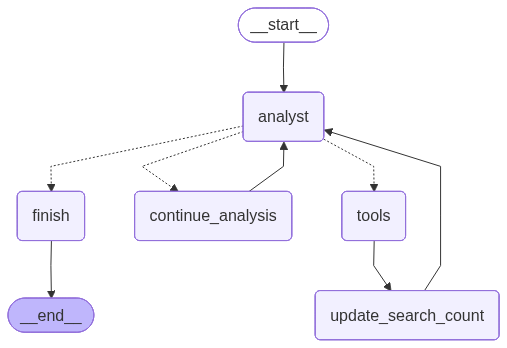

In [22]:
stock_analysis_graph = create_analyst_subgraph("Value Investing",value_analyst_prompt)
display(Image(stock_analysis_graph.get_graph(xray=1).draw_mermaid_png(max_retries=10, retry_delay=5.0)))

In [23]:
def create_analysis_node(specialty, prompt_template):
    def analysis_node(state: StockAnalysisState) -> StockAnalysisState:
        ticker = state["ticker"]
        analyst = next(a for a in state["analysts"] if a.specialty == specialty)
        
        analyst_state = {
            "ticker": ticker,
            "analyst_name": analyst.name,
            "specialty": analyst.specialty,
            "focus_areas": analyst.focus_areas,
            "investment_horizon": analyst.investment_horizon,
            "data": state,
            "search_count": 0,
            "is_finished": False
        }
        
        # Create and run the analyst subgraph
        analyst_graph = create_analyst_subgraph(specialty, prompt_template)
        final_state = analyst_graph.invoke(analyst_state, {"recursion_limit": 20})

        # Return the analysis to the main graph
        return {"analyses": [{"analyst": analyst.name, "specialty": specialty, "content": final_state["final_analysis"]}]}

    return analysis_node

In [24]:
growth_tech_analyst_node = create_analysis_node("Growth & Technology Analysis", growth_tech_analyst_prompt)
value_analysis_node = create_analysis_node("Value Investing", value_analyst_prompt)
retail_longterm_analyst_node = create_analysis_node("Retail & Long-Term Strategy", retail_longterm_analyst_prompt)

In [25]:
def synthesize_reports_node(state: StockAnalysisState) -> StockAnalysisState:
    ticker = state["ticker"]
    analyses = state["analyses"]
    
    synthesis_prompt = f"""
You are a senior financial advisor synthesizing reports from multiple analysts about {ticker}.

Each analyst has provided their perspective and recommendation. Your task is to:

1. Summarize the key points from each analyst
2. Identify areas of agreement and disagreement
3. Create a balanced overall assessment

At the beginning of your synthesis, include the following disclaimer in bold:

**IMPORTANT DISCLAIMER: This analysis is for informational purposes only and does not constitute financial advice. The information provided should not be relied upon for investment decisions. Always conduct your own research and consult with a qualified financial advisor before making any investment.**

Here are the analyst reports:
"""
    
    for analysis in analyses:
        synthesis_prompt += f"\n--- {analysis['analyst']} ---\n{analysis['content']}\n"
    
    llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.2)

    # call llm.invoke via the observaility wrapper
    synthesis, span_id = log_llm_call(
        llm_call_func=llm.invoke,
        messages=[
            SystemMessage(content=synthesis_prompt),
            HumanMessage(content="Please synthesize these reports into a comprehensive analysis.")
        ],
        metadata={
            "analyst": "synthesize",
            "ticker": ticker
        }
    )
    
    return {"final_report": synthesis.content}

In [26]:
class StockRecommendation(enum.Enum):
    STRONG_BUY = 'strong buy'
    BUY = 'buy'
    HOLD = 'hold'
    SELL = 'sell'
    STRONG_SELL = 'strong sell'

class ConfidenceLevel(enum.Enum):
    HIGH = 'high'
    MEDIUM = 'medium'
    LOW = 'low'

In [27]:

def generate_structured_recommendation_node(state: StockAnalysisState) -> StockAnalysisState:
    """Generate a structured recommendation using Gemini's structured output feature"""
    ticker = state["ticker"]
    analyses = state["analyses"]

    # Format analyst reports
    analyst_reports = ""
    for analysis in analyses:
        analyst_reports += f"\n--- {analysis['analyst']} ---\n{analysis['content']}\n"
    
    chat = client.chats.create(model='gemini-2.5-flash')
    
    prompt = f"""
    Based on the following analyst reports for {ticker}, provide an investment recommendation:
    
    {analyst_reports}
    
    Consider factors like growth potential, valuation, competitive position, and market conditions.
    """
    
    response = chat.send_message(message=prompt)
    detailed_analysis = response.text
    
    # Now request a structured recommendation
    recommendation_config = types.GenerateContentConfig(
        response_mime_type="text/x.enum",
        response_schema=StockRecommendation,
    )
    rec_response = chat.send_message(
        message="Based on your analysis, what is your final recommendation? Choose from: strong buy, buy, hold, sell, strong sell.",
        config=recommendation_config,
    )
    recommendation = rec_response.parsed
    
    # Get confidence level
    confidence_config = types.GenerateContentConfig(
        response_mime_type="text/x.enum",
        response_schema=ConfidenceLevel,
    )
    conf_response = chat.send_message(
        message="What is your confidence level in this recommendation? Choose from: high, medium, low.",
        config=confidence_config,
    )
    confidence = conf_response.parsed
    
    # Get price targets as structured JSON
    price_target_schema = {
        "type": "object",
        "properties": {
            "low": {"type": "number"},
            "base": {"type": "number"},
            "high": {"type": "number"}
        }
    }
    
    price_target_config = types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=price_target_schema,
    )
    
    price_response = chat.send_message(
        message=f"Based on your analysis, provide price targets for {ticker} in JSON format with low, base, and high values.",
        config=price_target_config,
    )
    price_targets = price_response.parsed
    
    # Update state with structured outputs
    return {
        "recommendation": recommendation.value if recommendation else StockRecommendation.HOLD.value,
        "confidence": confidence.value if confidence else ConfidenceLevel.MEDIUM.value,
        "price_target": price_targets if price_targets else {"low": 0, "base": 0, "high": 0},
        "reasoning": detailed_analysis,
    }

In [28]:
def build_stock_analysis_graph():
    builder = StateGraph(StockAnalysisState)
    
    builder.add_node("collect_ticker", collect_ticker_node)
    builder.add_node("fetch_data", fetch_data_node)
    builder.add_node("analyze_market", market_context_node)
    builder.add_node("analyst_dispatch", analyst_dispatch_node)    
    builder.add_node("growth_tech_analysis", growth_tech_analyst_node)
    builder.add_node("value_analysis", value_analysis_node)
    builder.add_node("retail_longterm_analysis", retail_longterm_analyst_node)
    builder.add_node("synthesize_reports", synthesize_reports_node)
    builder.add_node("generate_recommendation", generate_structured_recommendation_node)
    
    builder.add_edge(START, "collect_ticker")
    builder.add_edge("collect_ticker", "fetch_data")
    builder.add_edge("fetch_data", "analyze_market")
    builder.add_edge("analyze_market", "analyst_dispatch")

    builder.add_edge("analyst_dispatch", "growth_tech_analysis")
    builder.add_edge("analyst_dispatch", "value_analysis")
    builder.add_edge("analyst_dispatch", "retail_longterm_analysis")

    builder.add_edge(["growth_tech_analysis", "value_analysis", "retail_longterm_analysis"], "synthesize_reports")
    builder.add_edge("synthesize_reports", "generate_recommendation")
    builder.add_edge("generate_recommendation", END)
    
    memory = MemorySaver()
    return builder.compile(checkpointer=memory)

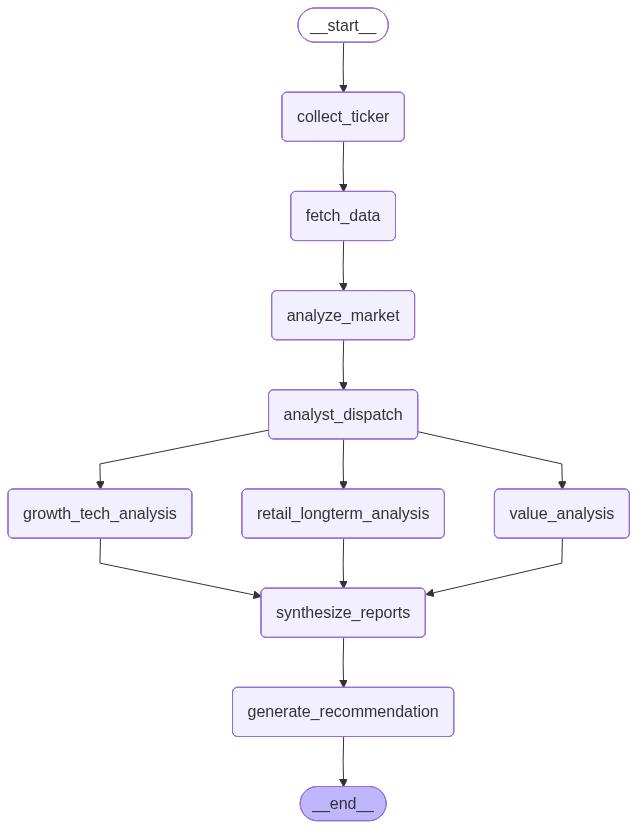

In [29]:
stock_analysis_graph = build_stock_analysis_graph()
display(Image(stock_analysis_graph.get_graph(xray=1).draw_mermaid_png(max_retries=10, retry_delay=5.0)))

In [30]:
def analyze_stock(ticker=None):
    """Run the stock analysis graph for a given ticker"""
    stock_analysis_graph = build_stock_analysis_graph()
    
    initial_state = {"ticker": ticker} if ticker else {}
    
    config = {
        "configurable": {
            "thread_id": "stock_research_analysis",
            "checkpoint_ns": "stock_research_analysis",
            "checkpoint_id": ticker or "unknown_ticker"
        }
    }
    
    final_state = stock_analysis_graph.invoke(initial_state, config=config)
    
    print("\n" + "="*50)
    print(f"ANALYSIS COMPLETE FOR: {final_state['ticker']}")
    print("="*50)
    
    print(f"\nRECOMMENDATION: {final_state['recommendation'].upper()}")
    print(f"CONFIDENCE: {final_state['confidence'].upper()}")
    
    if 'price_target' in final_state and all(k in final_state['price_target'] for k in ['low', 'base', 'high']):
        print(f"PRICE TARGETS:")
        print(f"  Low: ${final_state['price_target']['low']}")
        print(f"  Base: ${final_state['price_target']['base']}")
        print(f"  High: ${final_state['price_target']['high']}")

    # final synthesized report
    print("\n" + "="*50)
    print("SYNTHESIZED ANALYSIS:")
    print("="*50)
    print(final_state['final_report'])
    
    # individual analyst reports
    print("\n" + "="*50)
    print(f"INDIVIDUAL ANALYST REPORTS: ({len(final_state['analyses'])})")
    print("="*50)
    
    for analysis in final_state['analyses']:
        print("\n" + "-"*50)
        print(f"ANALYST: {analysis['analyst']}")
        print("-"*50)
        print(analysis['content'])

In [ ]:
analyze_stock("ASML")